# Arboles de decisión

# Arboles de decisión

## Ventajas

1. Los árboles son fáciles de interpretar aun cuando las relaciones entre predictores son complejas. Su estructura se asemejan a la forma intuitiva en que clasificamos y predecimos las personas, además, no se requieren conocimientos estadísticos para comprenderlos.

2. Los modelos basados en un solo árbol (no es el caso de random forest, boosting…) se pueden representar gráficamente aun cuando el número de predictores es mayor de 3.


3. Al tratarse de métodos no paramétricos, no es necesario que se cumpla ningún tipo de distribución específica.

4. Por lo general, requieren mucha menos limpieza y pre procesado de los datos en comparación a otros métodos de aprendizaje estadístico.

5. No se ven muy influenciados por outliers.

6. Si para alguna observación, el valor de un predictor no está disponible, a pesar de no poder llegar a ningún nodo terminal, se puede conseguir una predicción empleando todas las observaciones que pertenecen al último nodo alcanzado. La precisión de la predicción se verá reducida pero al menos podrá obtenerse.

7. Son muy útiles en la exploración de datos, permiten identificar de forma rápida y eficiente las variables más importantes.

8. Son capaces de seleccionar predictores de forma automática.

## Desventajas

1. La capacidad predictiva de los modelos de regresión y clasificación basados en un único árbol es bastante inferior a la conseguida con otros modelos debido a su tendencia al overfitting. Sin embargo, existen técnicas más complejas que, haciendo uso de la combinación de múltiples árboles (bagging, random forest, boosting), consiguen mejorar en gran medida este problema.

2. Cuando tratan con variables continuas, pierden parte de su información al categorizarlas en el momento de la división de los nodos. Por esta razón, suelen ser modelos que consiguen mejores resultados en clasificación que en regresión.

3. Tal y como se describe más adelante, la creación de las ramificaciones de los árboles se consigue mediante el algoritmo de recursive binary splitting. Este algoritmo identifica y evalúa las posibles divisiones de cada predictor acorde a una determinada medida (RSS, Gini, entropía…). Los predictores continuos o predictores cualitativos con muchos niveles tienen mayor probabilidad de contener, solo por azar, algún punto de corte óptimo, por lo que suelen verse favorecidos en la creación de los árboles.



# Arboles de regresión

Todo arbol se realiza en dos pasos, 

1. División de la región de predicción en $K$ subregiones $R_1\ldots R_K$ excluyentes, generalmente hiperrectangulos.

2. Se predice la variable en cada región.

Las regiones generalmente se seleccionan buscando reducir la suma de cuadrados de los residuales o *Residual Sum of Squares* definida como
$$RSS=\sum_{j=1}^K  \sum_{i\in R_j}(y_{ij}-\bar{y}_j)^2$$
Para encontrar estas regiones se usa el algoritmo *Recursive Binary splitting*

### Recursive Binary Splitting

Este algoritmo sigue los siguientes pasos.

1. Se inicia con todas las observaciones en el mismo nodo. 

2. Se calculan todos los umbrales para cada variable: Si es continua son los puntos medios de los datos ordenados y si es discreta cada categoria de las variables.
3. Se calcula la _RSS_ para cada umbral 

4. Se elije la variable $X_j$ y el umbral $S$ para la división que hace mínima la _RSS_

5. Se repite el proceso con cada grupo de observaciones resultantes hasta llegar a un punto de parada.
Los puntos de parada son muy importante en la construcción del arbol.

### Puntos de parada

1. Observaciones mínimas para división (Por defecto 10)

2. Observaciones mínimas de nodo terminal (Por defecto 5)

3. Cambio minimo porcentual de la devianza( Varianza) (Por defecto 0.01)

### Evitar el sobreajuste (overfitting)

EL overfitting se define cuando el arbol se ajusta muy bien a los datos de entrenamiento, pero no ajusta los datos de prueba.

### Podado del árbol (Tree prunning)

1. Se emplea _recursive binary splitting_ para crear un árbol grande y complejo empleando como única condición de parada el número mínimo de observaciones por nodo terminal.

2. Se aplica el _cost complexity pruning_  para obtener el mejor arbol.
_cost complexity pruning_= _Perdida_+ _Penalizacion_
Para esto se calcula primero el siguiente valor
$$ \sum_{i=1}^T \sum_{j\in R_{i}} (y_j-\bar{y}_i)^2 + \alpha T$$
Donde $T$ es el numero de divisiones del arbol y $\alpha$ es un valor entre mayor o igual a 0.

3. El valor optimo de $\alpha$ se obtiene mediante validación cruzada.

4. Se realiza el paso 2 con el valor de $\alpha$ del punto 3.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score
!pip install dtreeviz
from dtreeviz.trees import dtreeviz
from sklearn.model_selection import GridSearchCV

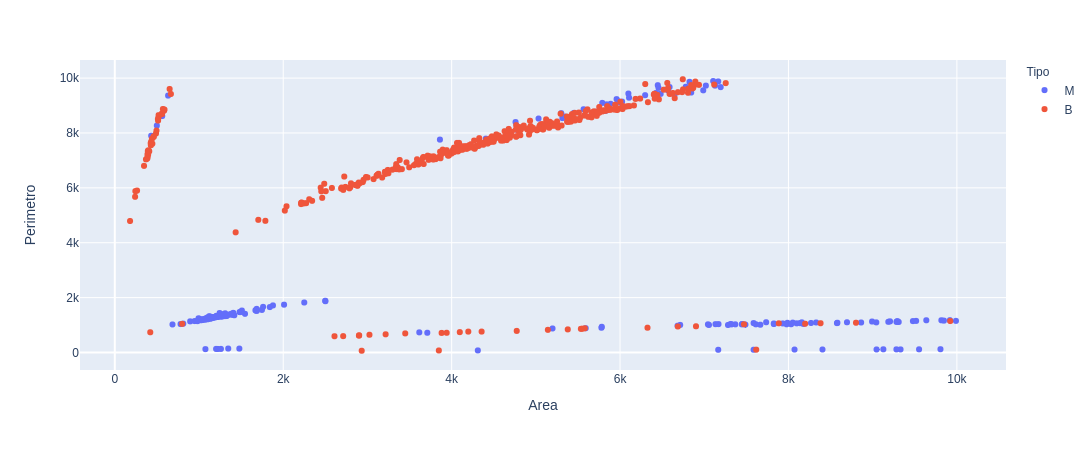

In [2]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Cancer.csv"
cancer=pd.read_csv(url, sep=";", index_col=0)
fig=px.scatter(cancer, x=cancer.Area, y=cancer.Perimetro, color=cancer.Tipo)
fig.show()

In [3]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Violencia.csv"
violencia=pd.read_csv(url, sep=";", decimal=",", na_values="?",index_col=0)
violencia=pd.get_dummies(violencia, drop_first=True) ## variables dummy
violencia1=violencia.drop(['murders', 'rapes', 'rapesPerPop',
       'robberies', 'robbbPerPop', 'assaults', 'assaultPerPop', 'burglaries',
       'burglPerPop', 'larcenies', 'larcPerPop', 'autoTheft',
       'autoTheftPerPop', 'arsons', 'arsonsPerPop', 'ViolentCrimesPerPop',
       'nonViolPerPop'], axis=1) ## Quitando todas las de crimen
violencia1=violencia1.select_dtypes(exclude=object)
b=violencia1.isna().sum()[violencia.isna().sum()/violencia.shape[0]<0.1]
X=violencia1[b.index]
X=X.dropna() ### Quito datos faltantes
Y=X["murdPerPop"]  ## Selecciono a Y
X=X.drop(["murdPerPop"], axis=1) 
X.shape
X.columns

Index(['fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite',
       'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
       'agePct16t24',
       ...
       'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT',
       'state_WA', 'state_WI', 'state_WV', 'state_WY'],
      dtype='object', length=150)

In [4]:
X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.2) ## Dividir a X en X train y X test
## Dividir a Y en Ytrain y Ytest en un proporcion 80/20. Si desea estratificar5 use Stratify
print("Tamaño de X", X.shape)
print("Tamaño de X-train", X_train.shape)

Tamaño de X (2214, 150)
Tamaño de X-train (1771, 150)


## Arbol de regresión 
Para realizar una arbol con Sklearn [Aqui](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)


In [5]:
arbol=tree.DecisionTreeRegressor(criterion='mse', min_samples_split=100, min_samples_leaf=50)
arbol=arbol.fit(X_train, y_train)

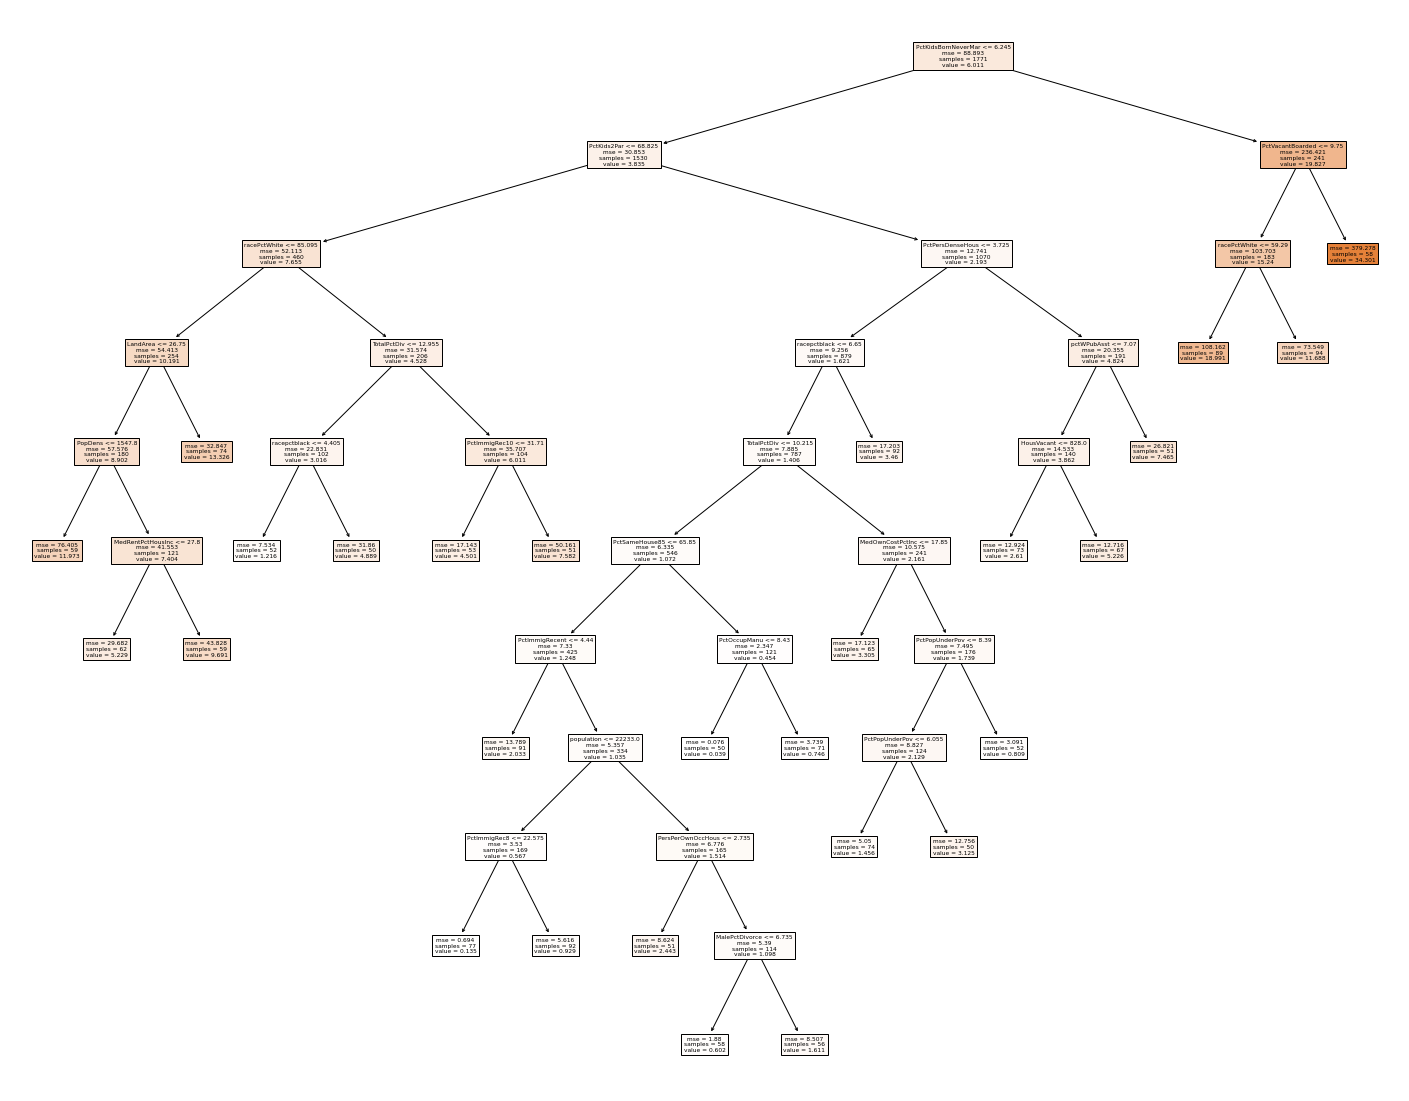

In [6]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [7]:
print("depth=",arbol.get_depth()) ### profundidad
print("Nodos terminales=",arbol.get_n_leaves()) ### profundidad

depth= 10
Nodos terminales= 27


In [8]:
viz = dtreeviz(arbol, X_train, y_train,
                target_name="target", feature_names=X_train.columns)

viz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


En el scoring se pueden colocar [metricas](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [9]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeRegressor(), parameters,scoring="neg_mean_squared_error", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

-47.26178539233028 {'max_depth': 3}


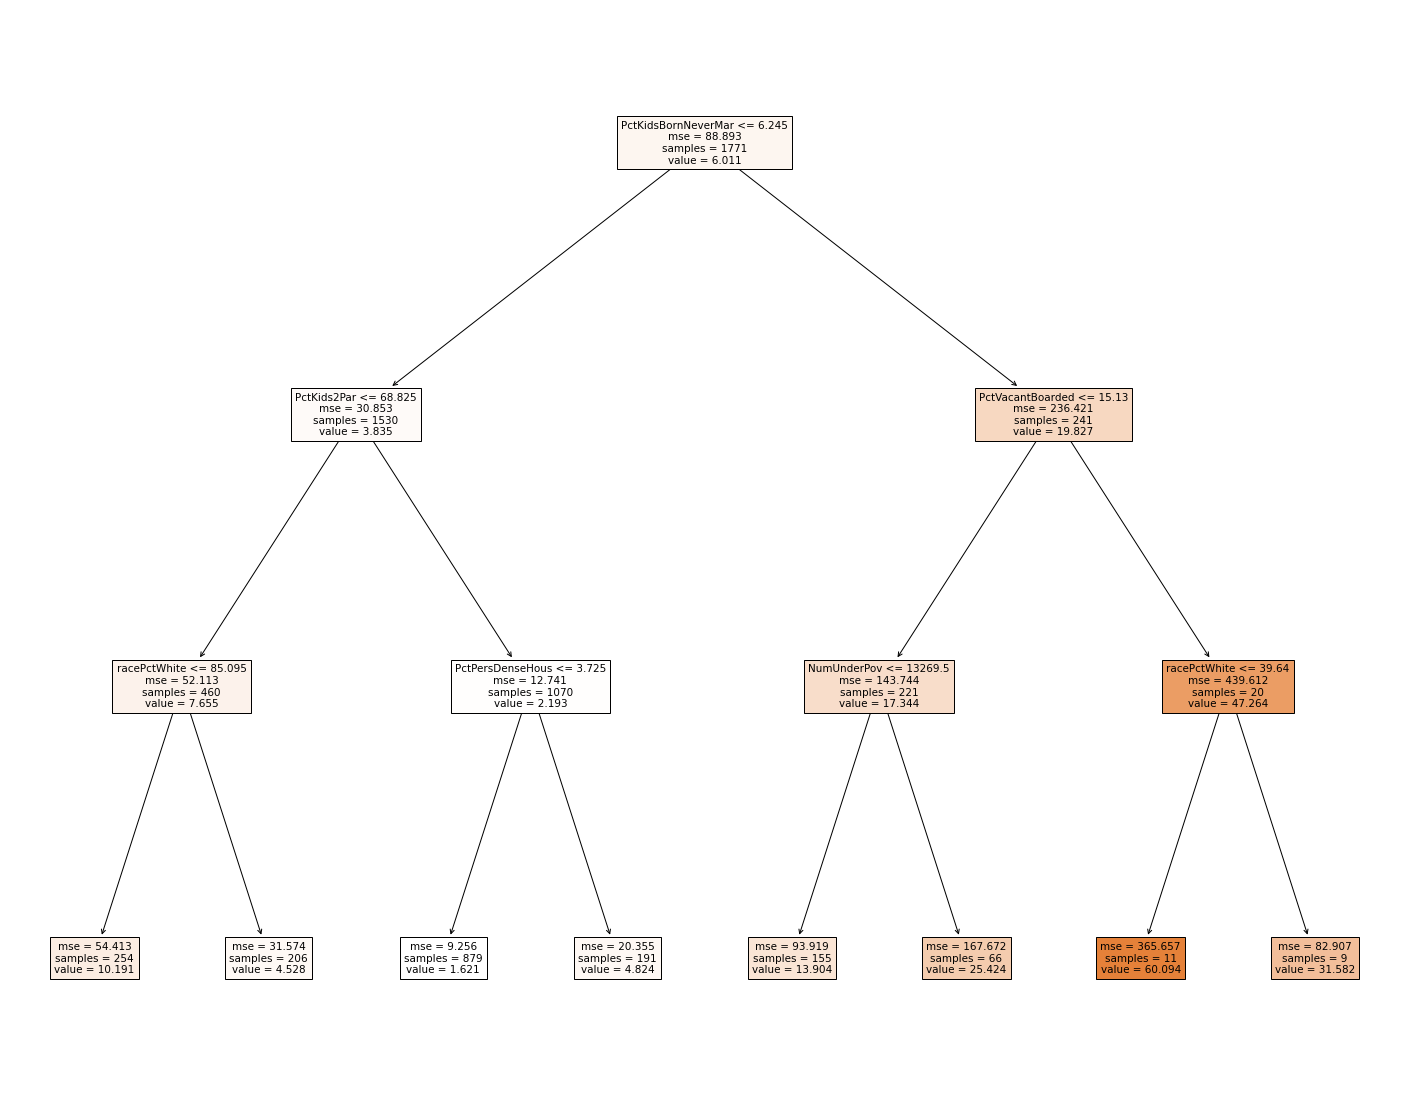

In [10]:
## Como me dice que una profundidad de 4
arbol=tree.DecisionTreeRegressor(criterion='mse', max_depth=3)
arbol=arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

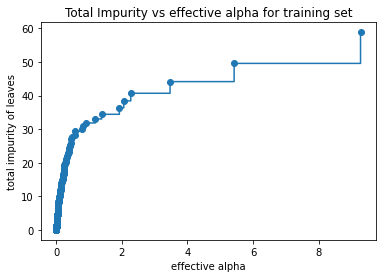

In [11]:
arbol = tree.DecisionTreeRegressor(random_state=0)
alpha= arbol.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = alpha.ccp_alphas, alpha.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

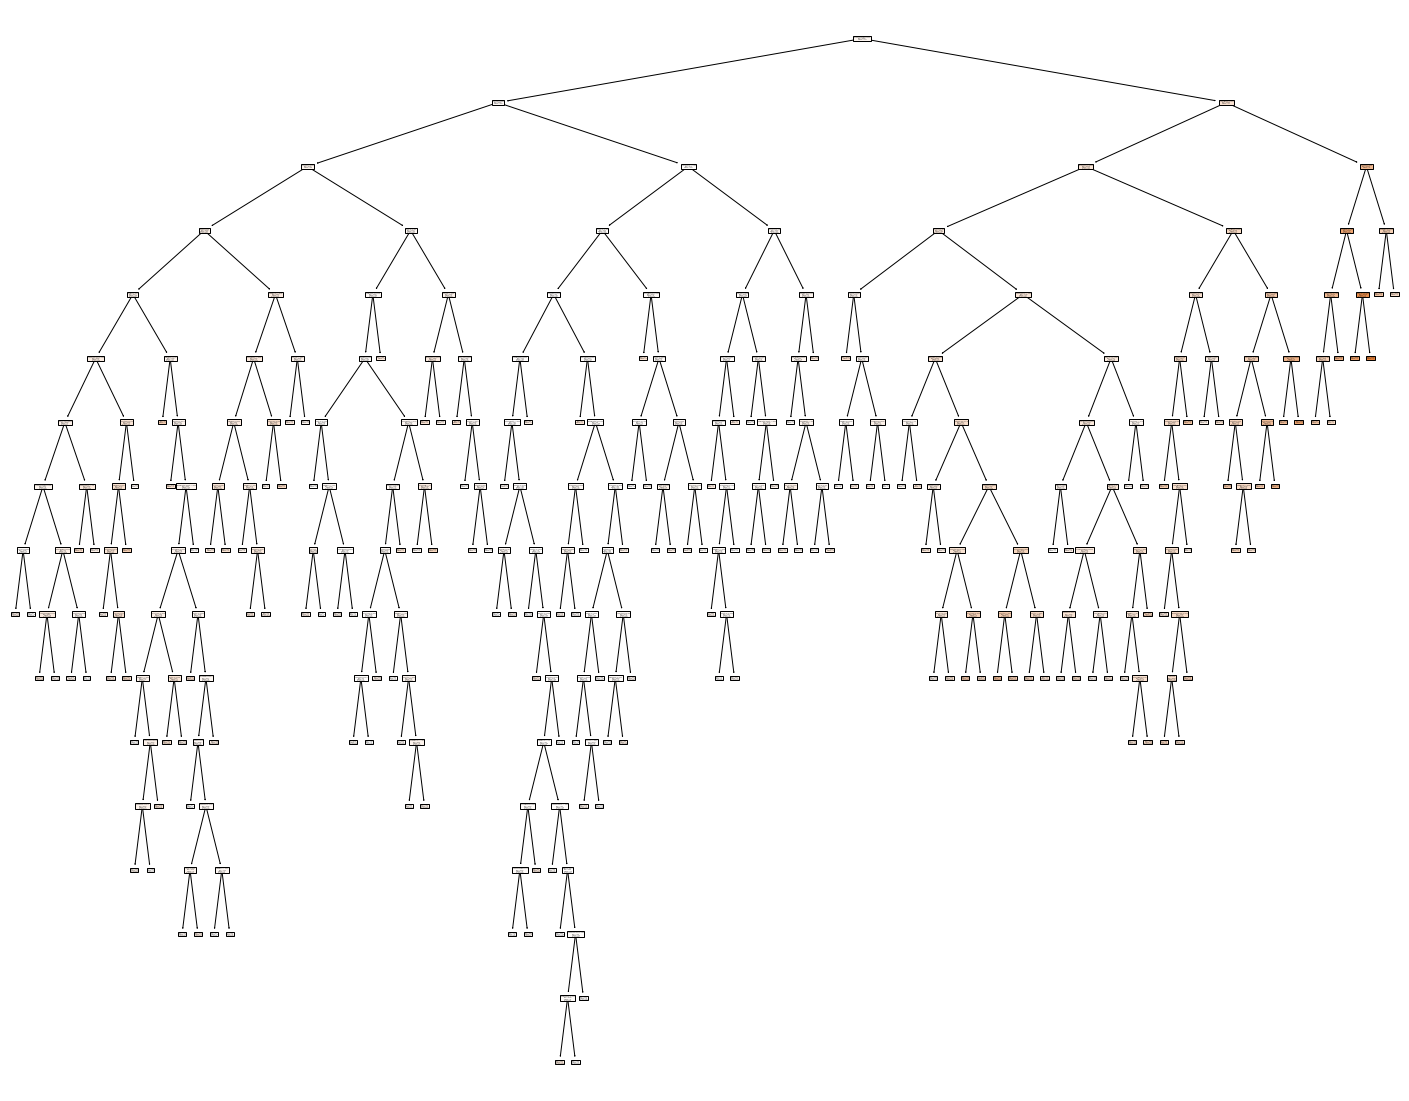

In [12]:
arbol=tree.DecisionTreeRegressor(criterion='mse',ccp_alpha=0.05)
arbol=arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [13]:
pred_train=arbol.predict(X_train) ## Pronosticando dentro del entrenamiento
print("El R2 es ",100*np.round(r2_score(y_train, pred_train),4), "%")

El R2 es  93.99 %


In [14]:
pred_test=arbol.predict(X_test) ## Pronosticando dentro de la prueba
print("El R2 es ",100*np.round(r2_score(y_test, pred_test),4), "%")

El R2 es  8.469999999999999 %


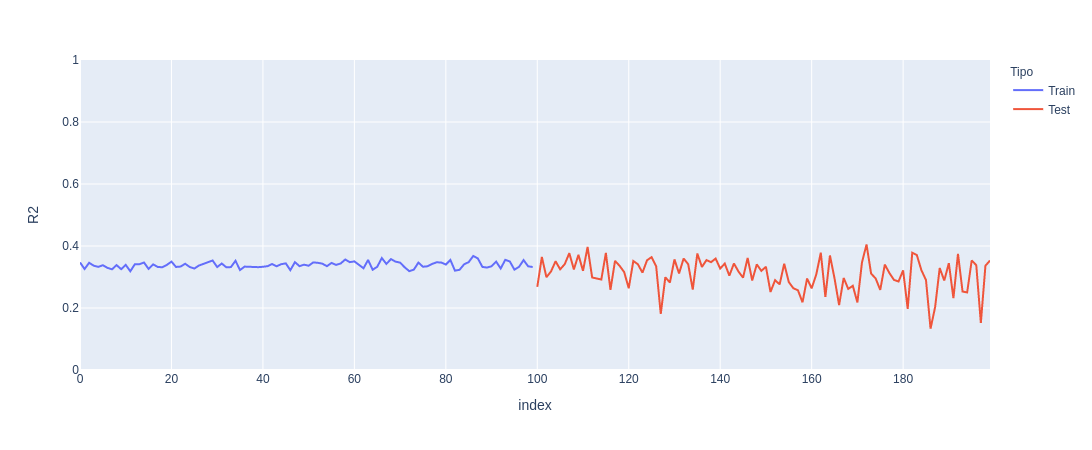

In [15]:
R2train=[]
R2test=[]
n=100
for i in range(n):
 X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.2) ## Dividir a X en X train y X test
 reg=tree.DecisionTreeRegressor(criterion='mse',ccp_alpha=20) ## llamo el arbol
 reg.fit(X_train,y_train)
 pred_train=reg.predict(X_train) ## Pronosticando dentro del entrenamiento
 R2train.append(r2_score(y_train, pred_train))
 pred_test=reg.predict(X_test)
 R2test.append(r2_score(y_test, pred_test))
sample=list(range(n))+list(range(n))
R2=R2train+R2test
tipo=["Train"]*n+["Test"]*n
datos=pd.DataFrame({"sample":sample, "R2":R2, "Tipo":tipo}, columns=["sample","R2", "Tipo"])
fig=px.line(datos,y=datos.R2, color=datos.Tipo, range_y=[0,1])
fig.show()

# Ejercicio con Hepatitis

Pronosticar la Albumina con un arbol de decisión

In [16]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Hepatitis.csv"
Hepatitis=pd.read_csv(url, sep=";", encoding="latin1", na_values=" ", decimal=",")
Hepa=pd.get_dummies(Hepatitis, drop_first=True) ## variables dummy
Y=Hepa["Albumina"] ## Variable objetivo
X=Hepa.drop(["Albumina"], axis=1) ## Variables explicativas
X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.2) ## Divido en train and test

In [17]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeRegressor(), parameters,scoring="neg_mean_squared_error", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

-1.5479447082167161 {'max_depth': 2}


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

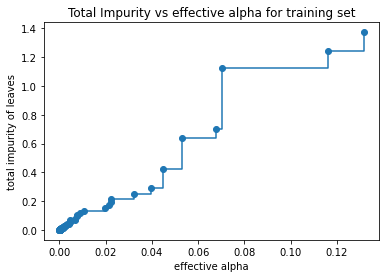

In [18]:
arbol = tree.DecisionTreeRegressor(random_state=0)
alpha= arbol.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = alpha.ccp_alphas, alpha.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

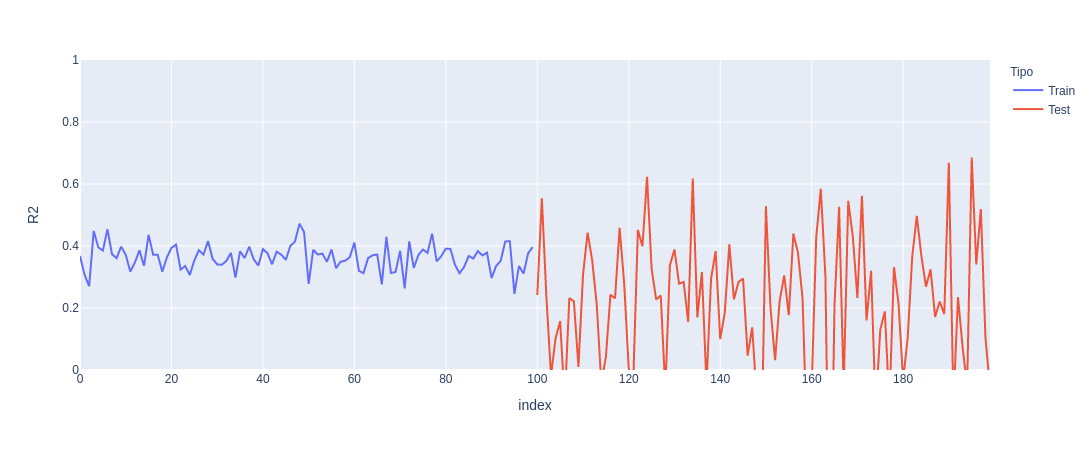

In [19]:
R2train=[]
R2test=[]
n=100
for i in range(n):
 X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.2) ## Dividir a X en X train y X test
 reg=tree.DecisionTreeRegressor(criterion='mse',max_depth=2) ## llamo el arbol
 reg.fit(X_train,y_train)
 pred_train=reg.predict(X_train) ## Pronosticando dentro del entrenamiento
 R2train.append(r2_score(y_train, pred_train))
 pred_test=reg.predict(X_test)
 R2test.append(r2_score(y_test, pred_test))
sample=list(range(n))+list(range(n))
R2=R2train+R2test
tipo=["Train"]*n+["Test"]*n
datos=pd.DataFrame({"sample":sample, "R2":R2, "Tipo":tipo}, columns=["sample","R2", "Tipo"])
fig=px.line(datos,y=datos.R2, color=datos.Tipo, range_y=[0,1])
fig.show()

# Ejercicio con bateadores

In [20]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/bateadores.csv"
bateadores=pd.read_csv(url, sep=";", na_values="NA", decimal=",", index_col=0)
bateadores=pd.get_dummies(bateadores, drop_first=True) ## variables dummy
bate=bateadores[bateadores.Salary.isna()==False]
bateNA=bateadores[bateadores.Salary.isna()==True]
Y=np.log(bate["Salary"]) ## Variable objetivo (extraigo el logaritmo)
X=bate.drop(["Salary"], axis=1) ## Variables explicativas
X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.2) ## Divido en train and test

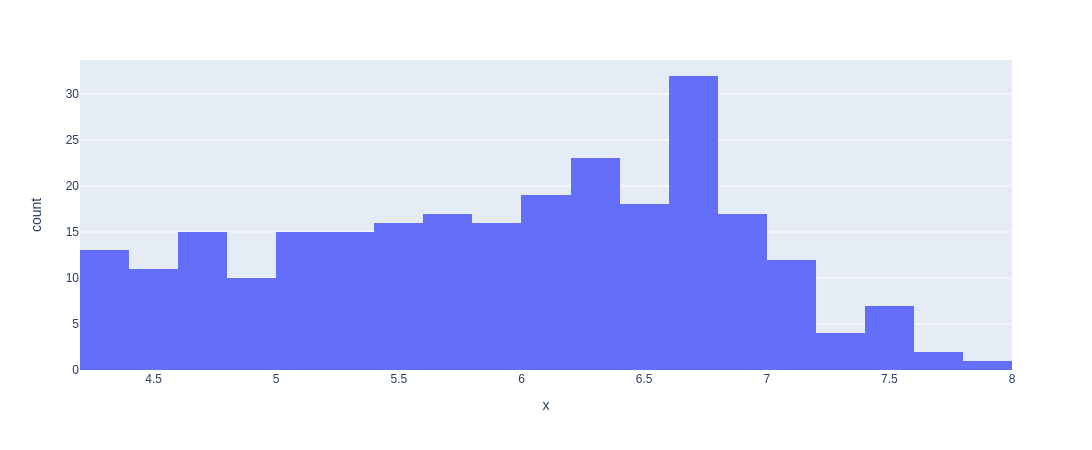

In [21]:
fig=px.histogram(bateadores, x=np.log(bateadores.Salary))
fig.show()

In [22]:
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeRegressor(), parameters,scoring="neg_mean_squared_error", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

-0.30390598062632057 {'max_depth': 4}


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

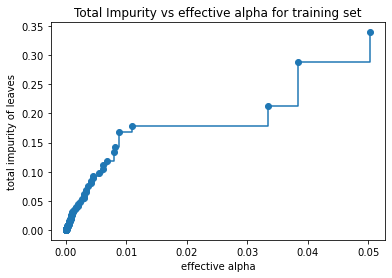

In [23]:
arbol = tree.DecisionTreeRegressor(random_state=0)
alpha= arbol.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = alpha.ccp_alphas, alpha.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

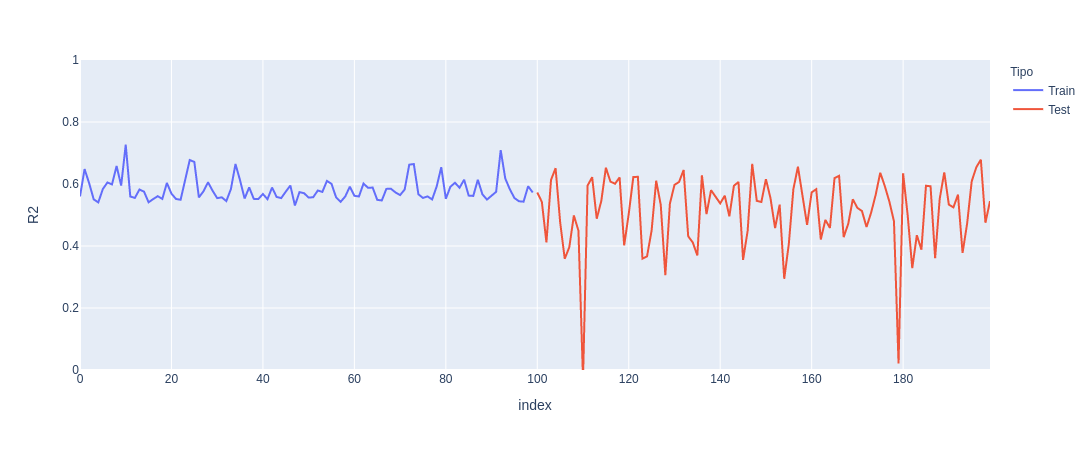

In [24]:
R2train=[]
R2test=[]
n=100
for i in range(n):
 X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.2) ## Dividir a X en X train y X test
 reg=tree.DecisionTreeRegressor(criterion='mse',ccp_alpha=0.06) ## llamo el arbol
 reg.fit(X_train,y_train)
 pred_train=reg.predict(X_train) ## Pronosticando dentro del entrenamiento
 R2train.append(r2_score(y_train, pred_train))
 pred_test=reg.predict(X_test)
 R2test.append(r2_score(y_test, pred_test))
sample=list(range(n))+list(range(n))
R2=R2train+R2test
tipo=["Train"]*n+["Test"]*n
datos=pd.DataFrame({"sample":sample, "R2":R2, "Tipo":tipo}, columns=["sample","R2", "Tipo"])
fig=px.line(datos,y=datos.R2, color=datos.Tipo, range_y=[0,1])
fig.show()

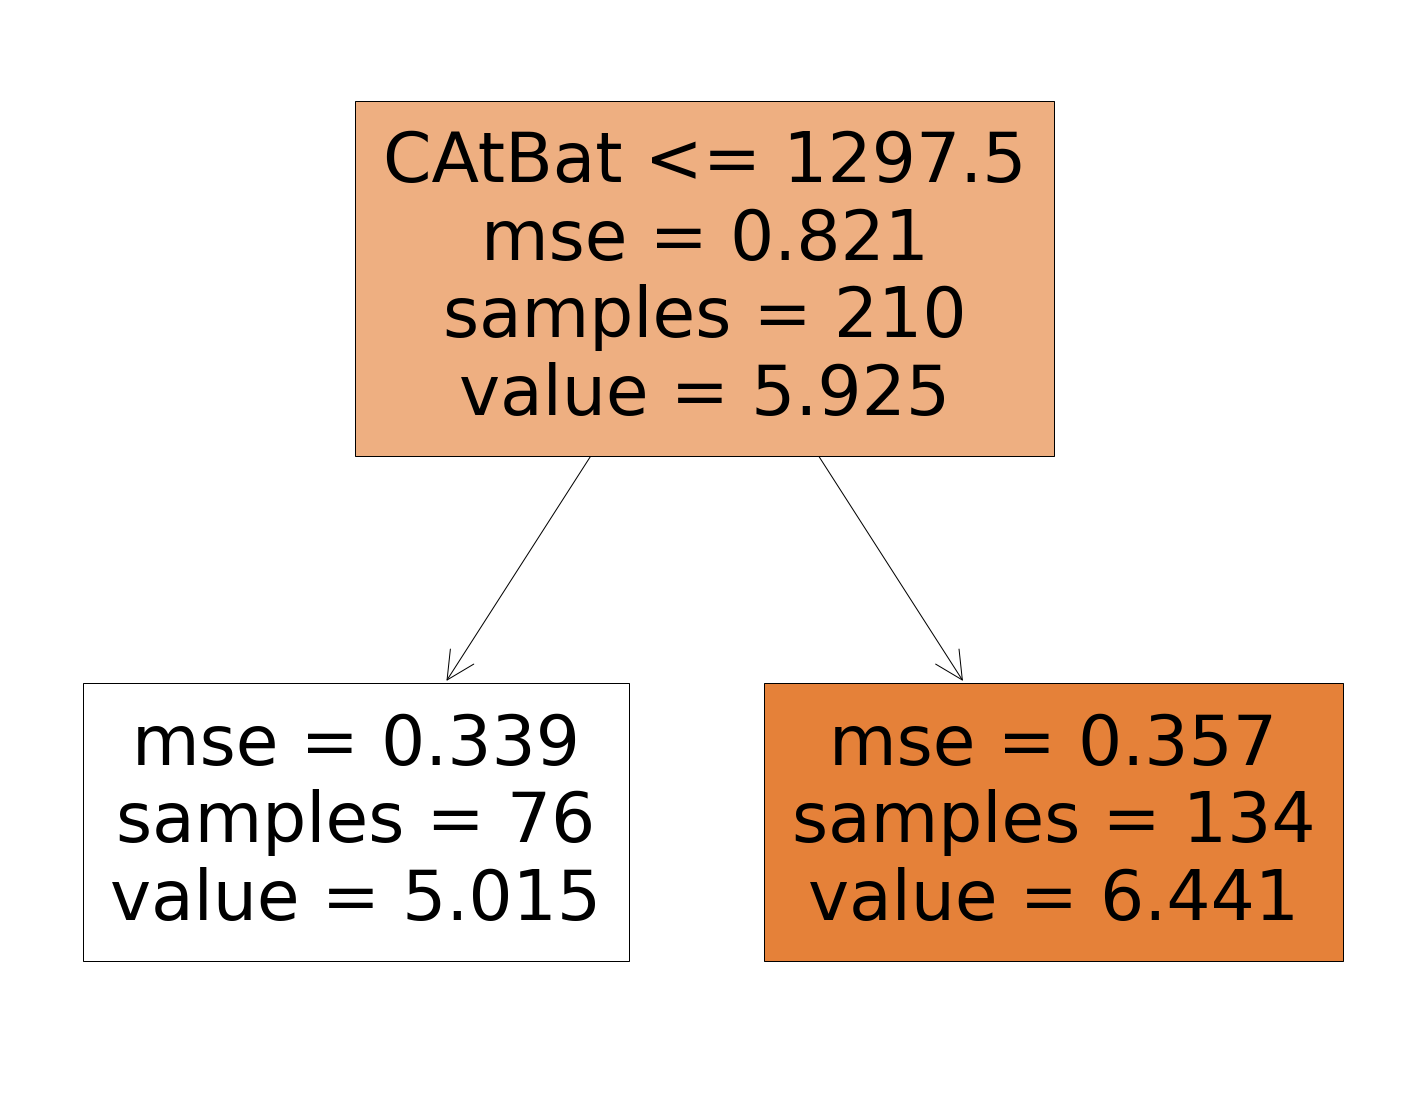

In [25]:
arbol=tree.DecisionTreeRegressor(criterion='mse',ccp_alpha=0.05) ### Salió de la depuración de la base
arbol=arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [28]:
arbol.predict(X_train)

array([6.44119127, 5.01479386, 6.44119127, 6.44119127, 5.01479386,
       6.44119127, 6.44119127, 6.44119127, 5.01479386, 6.44119127,
       5.01479386, 6.44119127, 6.44119127, 5.01479386, 6.44119127,
       5.01479386, 6.44119127, 5.01479386, 5.01479386, 6.44119127,
       6.44119127, 5.01479386, 5.01479386, 6.44119127, 6.44119127,
       5.01479386, 6.44119127, 6.44119127, 5.01479386, 6.44119127,
       6.44119127, 5.01479386, 6.44119127, 6.44119127, 6.44119127,
       6.44119127, 6.44119127, 5.01479386, 5.01479386, 6.44119127,
       6.44119127, 5.01479386, 6.44119127, 6.44119127, 5.01479386,
       5.01479386, 6.44119127, 6.44119127, 5.01479386, 5.01479386,
       6.44119127, 6.44119127, 6.44119127, 6.44119127, 5.01479386,
       6.44119127, 6.44119127, 6.44119127, 6.44119127, 6.44119127,
       6.44119127, 5.01479386, 6.44119127, 6.44119127, 6.44119127,
       6.44119127, 6.44119127, 5.01479386, 5.01479386, 5.01479386,
       6.44119127, 6.44119127, 6.44119127, 5.01479386, 5.01479

## Como tengo datos faltantes, los pronostico con el arbol


In [ ]:
XNA=bateNA.drop(["Salary"], axis=1) 
arbol.predict(XNA) ## Pronosticando los logaritmos de los salarios faltantes
np.exp(arbol.predict(XNA))

## Tarea

Con la base de Cereal, pronostican Calorias

Arbol, Alpha, Depth, R cuadrados

In [ ]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Cereal.csv"
cereal=pd.read_csv(url, sep=";", decimal=",", index_col=0)
cereal

In [ ]:
fig=px.histogram(cereal, x=cereal.Calorias)
fig.show()

In [ ]:
Y=np.log(cereal["Calorias"])
X=cereal.drop("Calorias", axis=1) ## Tiene cualitativas
X=pd.get_dummies(X, drop_first=True) ##Hago dummies
X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.2) ## Divido en train and test

In [ ]:
parameters = {'max_depth':range(2,20)} ### voy a probar desde 3 hasta 20
arbol= GridSearchCV(tree.DecisionTreeRegressor(), parameters,scoring="r2", n_jobs=-1) ## Metrica r2
arbol.fit(X=X_train, y=y_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

In [ ]:
arbol=tree.DecisionTreeRegressor(criterion='mse',max_depth=3)
arbol=arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [ ]:
Y_pred_train=arbol.predict(X_train)
print("R2 de entrenamiento",r2_score(y_train, Y_pred_train))

In [ ]:
Y_pred_test=arbol.predict(X_test)
print("R2 de entrenamiento",r2_score(y_test, Y_pred_test))

In [ ]:
arbol = tree.DecisionTreeRegressor(random_state=0)
alpha= arbol.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = alpha.ccp_alphas, alpha.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
arbol=tree.DecisionTreeRegressor(criterion='mse',ccp_alpha=0.0025)
arbol=arbol.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(arbol, feature_names=X_train.columns, filled=True)

In [ ]:
Y_pred_train=arbol.predict(X_train)
print("R2 de entrenamiento",r2_score(y_train, Y_pred_train))
Y_pred_test=arbol.predict(X_test)
print("R2 de prueba",r2_score(y_test, Y_pred_test))